In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from invisible_cities.core.core_functions  import shift_to_bin_centers
from invisible_cities.core                 import fit_functions as fitf

In [2]:
def hist(*args, **kwargs):
    """
    Create a figure and then the histogram
    """
    create_new_figure(kwargs)

    y, x, p = plt.hist(*args, **kwargs)
    return y, shift_to_bin_centers(x), p


def hist2d(*args, **kwargs):
    """
    Create a figure and then the histogram
    """
    create_new_figure(kwargs)

    z, x, y, p = plt.hist2d(*args, **kwargs)
    return z, shift_to_bin_centers(x), shift_to_bin_centers(y), p

def hist2d_profile(x, y, z, nbinx, nbiny, xrange, yrange, **kwargs):
    """
    Create a profile 2d of the data and plot it as an histogram.
    """
    x, y, z, ze = fitf.profileXY(x, y, z, nbinx, nbiny, xrange, yrange)
    plot_output = display_matrix(x, y, z, **kwargs)
    return ((x, y, z, ze), *plot_output)

def display_matrix(x, y, z, mask=None, **kwargs):
    """
    Display the matrix z using the coordinates x and y as the bin centers.
    """
    nx = x = np.size(x)
    ny = np.size(y)

    dx = (np.max(x) - np.min(x)) / nx
    dy = (np.max(y) - np.min(y)) / ny

    x_binning = np.linspace(np.min(x) - dx, np.max(x) + dx, nx + 1)
    y_binning = np.linspace(np.min(y) - dy, np.max(y) + dy, ny + 1)

    x_ = np.repeat(x, ny)
    y_ = np.tile  (y, nx)
    z_ = z.flatten()

    if mask is None:
        mask = np.ones_like(z_, dtype=bool)
    else:
        mask = mask.flatten()
    h  = hist2d(x_[mask], y_[mask], (x_binning,
                                     y_binning),
                weights = z_[mask],
                **kwargs)
    return h, plt.colorbar()

def create_new_figure(kwargs):
    if kwargs.setdefault("new_figure", True):
        plt.figure()
    del kwargs["new_figure"]

def labels(xlabel, ylabel, title=""):
    """
    Set x and y labels.
    """
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title ( title)

In [3]:
file_name = "flex.kr83m.1.s3mmp15mm.nexus.h5"
this_dir = "/Users/taylorcontreras/Development/Research/Odyssey_sipmstudy/"

In [4]:
# Get all sensor responses and all the sensor positions
sns_response = pd.read_hdf(this_dir+file_name, 'MC/sns_response')
sns_positions = pd.read_hdf(this_dir+file_name, 'MC/sns_positions')

# Sort to get the sipm positions
sns_pos_sorted = sns_positions.sort_values(by=['sensor_id'])
sipm_positions = sns_pos_sorted[sns_pos_sorted["sensor_name"].str.contains("SiPM")]

# Create separate dataframes for the sipm and pmt response
sns_response_sorted = sns_response.sort_values(by=['sensor_id'])
sipm_response = sns_response_sorted.loc[sns_response_sorted["sensor_id"] >999]
pmt_response = sns_response_sorted.loc[sns_response_sorted["sensor_id"] < 60]

# Summed pmt energy per event
response_perevent_pmt = pmt_response.groupby('event_id')
summed_charges_byevent_pmt = response_perevent_pmt.agg({"charge":"sum"})

# Summed sipm energy per event
response_perevent_sipm = sipm_response.groupby('event_id')
summed_charges_byevent_sipm = response_perevent_sipm.agg({"charge":"sum"})

# Position of the event(sipm with the max charge)
idx = sipm_response.groupby(['event_id'])['charge'].transform(max) == sipm_response['charge']
max_sipms = sipm_response[idx].sort_values('sensor_id').set_index('sensor_id')
new_max_sipm_positions = sipm_positions.set_index('sensor_id')
this = new_max_sipm_positions.loc[max_sipms.index.values.tolist()] 
event_map = pd.concat([max_sipms.loc[:,'event_id'],this.loc[:,['x','y','z']]], axis=1).set_index('event_id').sort_values(by='event_id')

pmt_map = pd.concat([summed_charges_byevent_pmt,event_map],axis=1)
sipm_map = pd.concat([summed_charges_byevent_sipm,event_map],axis=1)

# Make position a function of r
pmt_r = pmt_map.apply(lambda row: np.sqrt(row.x**2 + row.y**2), axis=1)
pmt_r = pmt_r.to_frame()
pmt_r = pmt_r.rename(columns = {pmt_r.columns[0]:'r'})
pmt_map = pd.concat([pmt_map, pmt_r],axis=1).sort_values(by='r')
sipm_r = sipm_map.apply(lambda row: np.sqrt(row.x**2 + row.y**2), axis=1)
sipm_r = sipm_r.to_frame()
sipm_r = sipm_r.rename(columns = {sipm_r.columns[0]:'r'})
sipm_map = pd.concat([sipm_map, sipm_r],axis=1).sort_values(by='r')

In [5]:
def Center_of_Event(sipm_response_in_event, sipm_positions):
    sensor_ids = sipm_response_in_event.sensor_id
    sensor_positions = sipm_positions.loc[sensor_ids]
    
    denominator = np.sum(sipm_response_in_event.charge)
    numerator = np.sum(sipm_response_in_event.set_index('sensor_id').charge*sensor_positions)

    return numerator/denominator

def Thresh_by_Event(group):
    return group[group.charge > max(group.charge)*.1]

In [6]:
# Set the event position as center of mass
sipm_response_by_event = sipm_response.groupby('event_id')
thresh_sipm_response = sipm_response_by_event.apply(Thresh_by_Event).set_index('event_id').groupby('event_id')
event_x = thresh_sipm_response.apply(lambda row: Center_of_Event(row,sipm_positions.set_index('sensor_id').x))
event_x = pd.DataFrame({'event_id':event_x.index,'x':event_x.values}).set_index('event_id')
event_y = thresh_sipm_response.apply(lambda row: Center_of_Event(row,sipm_positions.set_index('sensor_id').y))
event_y = pd.DataFrame({'event_id':event_y.index,'y':event_y.values}).set_index('event_id')

sipm_charge = sipm_response_by_event.agg({"charge":"sum"}).rename(columns={'charge':'sipm_charge'})
pmt_charge = pmt_response.groupby('event_id').agg({"charge":"sum"}).rename(columns={'charge':'pmt_charge'})
kr_map = pd.concat([pmt_charge,sipm_charge,event_x,event_y],axis=1)
kr_map

,pmt_charge,sipm_charge,x,y
event_id,,,,
100,7420,8194,140.099273,348.676114
101,7387,7945,182.011598,343.189317
102,6780,7280,458.622047,11.437008
103,7346,7887,-0.986590,-404.549808
104,7790,7819,236.646091,-141.352881
105,6319,6998,376.791992,-269.150391
106,6797,7298,449.169708,-61.669708
107,7485,8034,331.664439,-184.732620
108,8043,7885,-94.801020,37.147959


# Testing center positions

In [124]:
def Center_of_Event(sipm_response_in_event, sipm_positions):
    top_sipms = sipm_response_in_event[sipm_response_in_event.charge > max(sipm_response_in_event.charge)*.1]
    sensor_positions = sipm_positions.loc[sipm_positions.sensor_id.isin(top_sipms.sensor_id.tolist())]
    sensor_positions = sensor_positions.reindex(sensor_positions.index.repeat(top_sipms.groupby('sensor_id').sensor_id.count().values))
    top_sipms = top_sipms.merge(sensor_positions)
    
    x = np.sum(top_sipms.charge*top_sipms.x)/np.sum(top_sipms.charge)
    y = np.sum(top_sipms.charge*top_sipms.y)/np.sum(top_sipms.charge)
    z = np.sum(top_sipms.charge*top_sipms.z)/np.sum(top_sipms.charge)
    charge = np.sum(top_sipms.charge)
    event_id = top_sipms.event_id[0]
    
    return pd.Series({'event_id':event_id, 'charge':charge,'x':x, 'y':y, 'z':z})

In [127]:
test_mc = {'files':[this_dir+file_name], "size":3, "pitch":15, "dir": "s3mmp15mm"}
mcs = [test_mc]
for mc in mcs:
    print("Looping in mcs")
    pmt_map = pd.DataFrame()
    sipm_map = pd.DataFrame()
    pmt_timing = pd.DataFrame()
    sipm_timing = pd.DataFrame()

    for file in mc["files"]:
        print("Looping files in mc")
        # Get all sensor responses and all the sensor positions
        sns_response = pd.read_hdf(file, 'MC/sns_response')
        sns_positions = pd.read_hdf(file, 'MC/sns_positions')

        # Sort to get the sipm positions
        sns_pos_sorted = sns_positions.sort_values(by=['sensor_id'])
        sipm_positions = sns_pos_sorted[sns_pos_sorted["sensor_name"].str.contains("SiPM")]

        # Create separate dataframes for the sipm and pmt response
        sns_response_sorted = sns_response.sort_values(by=['sensor_id'])
        sipm_response = sns_response_sorted.loc[sns_response_sorted["sensor_id"] >999]
        pmt_response = sns_response_sorted.loc[sns_response_sorted["sensor_id"] < 60]
        sipm_response = sipm_response.loc[sipm_response["time_bin"] >0]
        pmt_response = pmt_response.loc[pmt_response["time_bin"] >0]

        # Time length of events
        pmt_timing = pmt_timing.append(pmt_response.groupby(['event_id'])\
                        .apply(lambda group: group['time_bin'].max() - group['time_bin'].min()).to_frame())
        sipm_timing = sipm_timing.append(sipm_response.groupby(['event_id'])\
                        .apply(lambda group: group['time_bin'].max() - group['time_bin'].min()).to_frame())


        # Summed pmt energy per event
        response_perevent_pmt = pmt_response.groupby('event_id')
        summed_charges_byevent_pmt = response_perevent_pmt.agg({"charge":"sum"})

        # Summed sipm energy per event
        response_perevent_sipm = sipm_response.groupby('event_id')
        summed_charges_byevent_sipm = response_perevent_sipm.agg({"charge":"sum"})
        
        dark_rate = 10.
        dark_count  = sipm_timing*dark_rate
        dark_count = dark_count.rename(columns={0:'dark_count'})
        this = summed_charges_byevent_sipm.groupby('event_id')
        summed_charged_byevent_sipm = this.apply(Thresh_by_Event, args=(dark_count))#.set_index('event_id') #.groupby('event_id')

        # Position of the event(sipm with the max charge)
        sipm_map = sipm_map.append(sipm_response.groupby('event_id').apply(Center_of_Event, sipm_positions))


Looping in mcs
Looping files in mc


In [128]:
sipm_map

,event_id,charge,x,y,z
event_id,,,,,
100,100.0,27072.0,140.513630,347.760417,-23.301001
101,101.0,17266.0,182.303081,343.440577,-23.301001
102,102.0,20242.0,458.996147,12.385634,-23.301001
103,103.0,22497.0,-1.403187,-404.479597,-23.301001
104,104.0,16855.0,236.982646,-142.121774,-23.301001
105,105.0,22581.0,377.444865,-270.228179,-23.301001
106,106.0,23705.0,449.712402,-62.699747,-23.301001
107,107.0,21080.0,331.323529,-184.752609,-23.301001
108,108.0,17984.0,-94.626613,37.651802,-23.301001


In [115]:
# Testing positions of event as center of mass (energy)
i = 0
event_map = pd.DataFrame()
for _, grp in sipm_response.groupby('event_id'):
    if i == 10:
        break
    i += 1
    
    this = grp[grp.charge > max(grp.charge)*.1]
    sensor_positions = sipm_positions.loc[sipm_positions.sensor_id.isin(this.sensor_id.tolist())]
    sensor_positions_rep = sensor_positions.reindex(sensor_positions.index.repeat(this.groupby('sensor_id').sensor_id.count().values))
    this = this.merge(sensor_positions_rep)
    
    x = np.sum(this.charge*this.x)/np.sum(this.charge)
    y = np.sum(this.charge*this.y)/np.sum(this.charge)
    z = np.sum(this.charge*this.z)/np.sum(this.charge)
    charge = np.sum(this.charge)
    event_id = this.event_id[0]
    
    event_map = event_map.append(pd.Series({'event_id':event_id, 'charge':charge,'x':x, 'y':y, 'z':z}), ignore_index=True)
    
    #print(Center_of_Event(this, sipm_positions))
    #print(grp[grp.charge > max(grp.charge)*.1])
    #print(Center_of_Event(grp[grp.charge > max(grp.charge)*.1], sipm_positions)) #filter(lambda row: row.charge > max(grp.charge)*.1)
    #sensor_ids = grp.sensor_id
    #sensor_positions = sipm_positions.set_index('sensor_id').loc[sensor_ids]
    #plt.hist2d(sensor_positions.x, sensor_positions.y, weights=grp.set_index('sensor_id').charge, bins=50)
    #plt.show()
    
print(event_map.set_index('event_id'))

           charge           x           y          z
event_id                                            
100.0     27072.0  140.513630  347.760417 -23.301001
101.0     17266.0  182.303081  343.440577 -23.301001
102.0     20242.0  458.996147   12.385634 -23.301001
103.0     22497.0   -1.403187 -404.479597 -23.301001
104.0     16855.0  236.982646 -142.121774 -23.301001
105.0     22581.0  377.444865 -270.228179 -23.301001
106.0     23705.0  449.712402  -62.699747 -23.301001
107.0     21080.0  331.323529 -184.752609 -23.301001
108.0     17984.0  -94.626613   37.651802 -23.301001
109.0     18483.0 -260.062896  286.770411 -23.301001


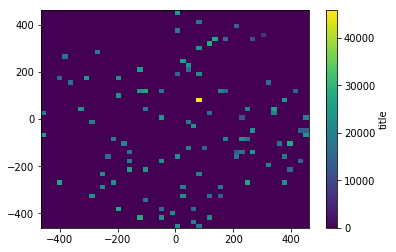

In [129]:
#plt.plot(sipm_map.r, sipm_map.charge)
#plt.plot(pmt_map.r, pmt_map.charge)

plt.hist2d(sipm_map.x, sipm_map.y, weights = sipm_map.charge, bins=[50,50])
plt.colorbar(label='title')

In [9]:
# Need to figure set pmt position to the position of highest sipm in that event


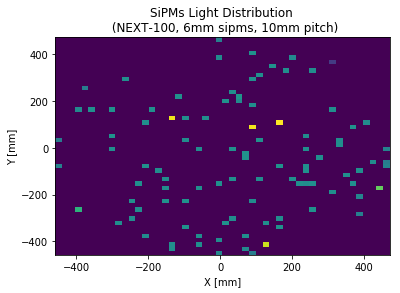

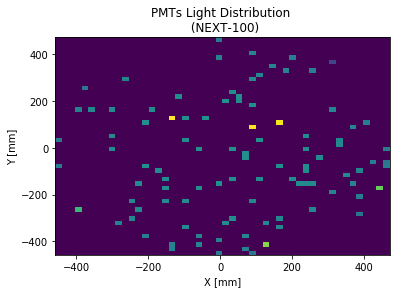

In [10]:
nbins = 500/10
h = hist2d(sipm_map.x, sipm_map.y, (nbins, nbins), weights = sipm_map.charge)
labels("X [mm]", "Y [mm]", "SiPMs Light Distribution \n (NEXT-100, 6mm sipms, 10mm pitch)")

h2 = hist2d(pmt_map.x, pmt_map.y, (nbins, nbins), weights = pmt_map.charge)
labels("X [mm]", "Y [mm]", "PMTs Light Distribution \n (NEXT-100)")

# Testing with thresholding for dark noise

In [14]:
def Thresh_by_Event(group, args=dark_count):
    event = group.index.tolist()[0] #.event_id.max()
    thresh = dark_count.loc[event].dark_count
    return group[group.charge > thresh]

In [15]:
test_mc = {'files':[this_dir+file_name], "size":3, "pitch":15, "dir": "s3mmp15mm"}
mcs = [test_mc]
for mc in mcs:
    print("Looping in mcs")
    pmt_map = pd.DataFrame()
    sipm_map = pd.DataFrame()
    pmt_timing = pd.DataFrame()
    sipm_timing = pd.DataFrame()

    for file in mc["files"]:
        print("Looping files in mc")
        # Get all sensor responses and all the sensor positions
        sns_response = pd.read_hdf(file, 'MC/sns_response')
        sns_positions = pd.read_hdf(file, 'MC/sns_positions')

        # Sort to get the sipm positions
        sns_pos_sorted = sns_positions.sort_values(by=['sensor_id'])
        sipm_positions = sns_pos_sorted[sns_pos_sorted["sensor_name"].str.contains("SiPM")]

        # Create separate dataframes for the sipm and pmt response
        sns_response_sorted = sns_response.sort_values(by=['sensor_id'])
        sipm_response = sns_response_sorted.loc[sns_response_sorted["sensor_id"] >999]
        pmt_response = sns_response_sorted.loc[sns_response_sorted["sensor_id"] < 60]
        sipm_response = sipm_response.loc[sipm_response["time_bin"] >0]
        pmt_response = pmt_response.loc[pmt_response["time_bin"] >0]

        # Time length of events
        pmt_timing = pmt_timing.append(pmt_response.groupby(['event_id'])\
                        .apply(lambda group: group['time_bin'].max() - group['time_bin'].min()).to_frame())
        sipm_timing = sipm_timing.append(sipm_response.groupby(['event_id'])\
                        .apply(lambda group: group['time_bin'].max() - group['time_bin'].min()).to_frame())


        # Summed pmt energy per event
        response_perevent_pmt = pmt_response.groupby('event_id')
        summed_charges_byevent_pmt = response_perevent_pmt.agg({"charge":"sum"})

        # Summed sipm energy per event
        response_perevent_sipm = sipm_response.groupby('event_id')
        summed_charges_byevent_sipm = response_perevent_sipm.agg({"charge":"sum"})
        
        dark_rate = 10.
        dark_count  = sipm_timing*dark_rate
        dark_count = dark_count.rename(columns={0:'dark_count'})
        this = summed_charges_byevent_sipm.groupby('event_id')
        summed_charged_byevent_sipm = this.apply(Thresh_by_Event, args=(dark_count))#.set_index('event_id') #.groupby('event_id')

        # Position of the event(sipm with the max charge)
        sipm_response = sipm_response[sipm_response.event_id.isin(summed_charges_byevent_sipm.index)]
        idx = sipm_response.groupby(['event_id'])['charge'].transform(max) == sipm_response['charge']
        max_sipms = sipm_response[idx].sort_values('sensor_id').set_index('sensor_id')
        new_max_sipm_positions = sipm_positions.set_index('sensor_id')
        this = new_max_sipm_positions.loc[max_sipms.index.values.tolist()]
        event_map = pd.concat([max_sipms.loc[:,'event_id'],this.loc[:,['x','y','z']]], axis=1).set_index('event_id').sort_values(by='event_id') 
        
        pmt_map = pmt_map.append(pd.concat([summed_charges_byevent_pmt,event_map],axis=1))
        sipm_map = sipm_map.append(pd.concat([summed_charges_byevent_sipm,event_map],axis=1))

Looping in mcs
Looping files in mc


In [16]:
sipm_response[sipm_response.event_id.isin(summed_charges_byevent_sipm.index)]#summed_charges_byevent_sipm.index] #summed_charges_byevent_sipm.index

,event_id,sensor_id,time_bin,charge
561782,158,1000,778,2
872763,191,1000,491,1
561781,158,1000,776,3
275513,128,1000,249,2
475747,149,1000,688,1
35214,103,1000,951,1
275514,128,1000,251,1
513654,153,1000,95,1
210201,121,1000,609,2
210204,121,1000,614,1


In [17]:
dark_rate = 10.
dark_count  = sipm_timing*dark_rate
dark_count = dark_count.rename(columns={0:'dark_count'})
this = summed_charges_byevent_sipm.groupby('event_id')
thresh_sipm_response = this.apply(Thresh_by_Event, args=(dark_count))#.set_index('event_id') #.groupby('event_id')
print(thresh_sipm_response)



                   charge
event_id event_id        
100      100         8192
101      101         7937
102      102         7270
103      103         7877
104      104         7809
105      105         6986
106      106         7289
107      107         8032
108      108         7879
109      109         8043
110      110         8036
111      111         7974
112      112         8266
113      113         8127
114      114         8039
115      115         7953
116      116         8107
117      117         8223
118      118         7815
119      119         7975
120      120         8151
121      121         7481
122      122         8200
123      123         7945
124      124         7736
125      125         7892
126      126         7421
127      127         8005
128      128         6839
129      129         7232
...                   ...
170      170         8573
171      171         8191
172      172         7924
173      173         8061
174      174         7936
175      175

In [18]:
sipm_response

,event_id,sensor_id,time_bin,charge
561782,158,1000,778,2
872763,191,1000,491,1
561781,158,1000,776,3
275513,128,1000,249,2
475747,149,1000,688,1
35214,103,1000,951,1
275514,128,1000,251,1
513654,153,1000,95,1
210201,121,1000,609,2
210204,121,1000,614,1
